In [1]:
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import optuna
import random
import joblib

results_dir = '../results/variables=[0,2]'
images_dir = '../images/variables=[0,2]'
data_dir = '../data/syntheticdata/variables=[0,2]'

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from utils.train_pipeline import ModelTrainingPipeline

seed = 1729

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('medium')
torch.cuda.set_per_process_memory_fraction(0.5, device=torch.device('cuda:0'))

ModelTrainingPipeline.set_seed(seed)

x = torch.rand(5, 3)
print(x)

The StatsForecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
#load data 
n = 100000 #number of data points
k = 3 #number of variables
p = 5 # pattern length
variable_indexes = np.arange(k)
variables_pattern = [0,2]

dataset_path = os.path.join(data_dir, "n={}_k={}_p={}_min_step={}_max_step={}_variables={}.csv".format(n, k, p, 5, 45, variables_pattern))
motif_indexes_path = os.path.join(data_dir, "motif_indexes_n={}_k={}_p={}_min_step={}_max_step={}.csv".format(n, k, p, 5, 45))
data = np.genfromtxt(dataset_path, delimiter=",").astype(int).reshape((k, n))
motif_indexes = np.genfromtxt(motif_indexes_path, delimiter=",").astype(int)

print(motif_indexes)


[    0     5    12 ... 99948 99965 99984]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


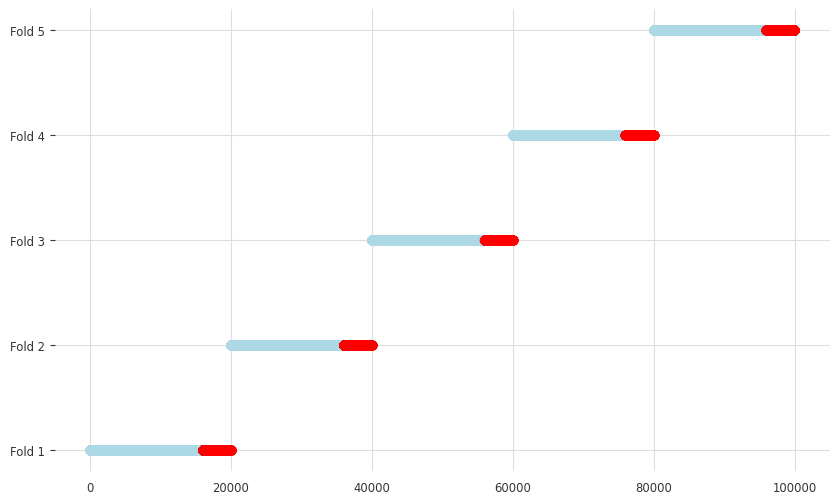

In [4]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [5]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#x1: past window, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2, y = create_dataset(data, variable_indexes, lookback_period, step, forecast_period, motif_indexes)

# X1, X2, and y are now PyTorch tensors
print("X1 shape:", X1.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X2 shape:", X2.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X1 shape: torch.Size([19977, 100, 3])
X2 shape: torch.Size([19977, 8])
y shape: torch.Size([19977, 1])


Number of finished trials:  10
Best trial: 6
Best hyperparameters: {'learning_rate': 0.0005603141314659803, 'kernel_size': 5, 'num_filters_1': 32, 'num_filters_2': 16, 'batch_size': 16}
Validation Losses [4.618163108825684, 6.553735256195068, 5.490455627441406, 3.8803019523620605, 2.7715046405792236]
Mean validation loss: 4.662832117080688
Test Losses [6.687633037567139, 9.142542839050293, 7.399514198303223, 3.5452041625976562, 4.130248069763184]
Mean test loss: 6.1810284614562985
Mean test MAE: 1.5818042755126953
Mean test RMSE: 2.449017357826233


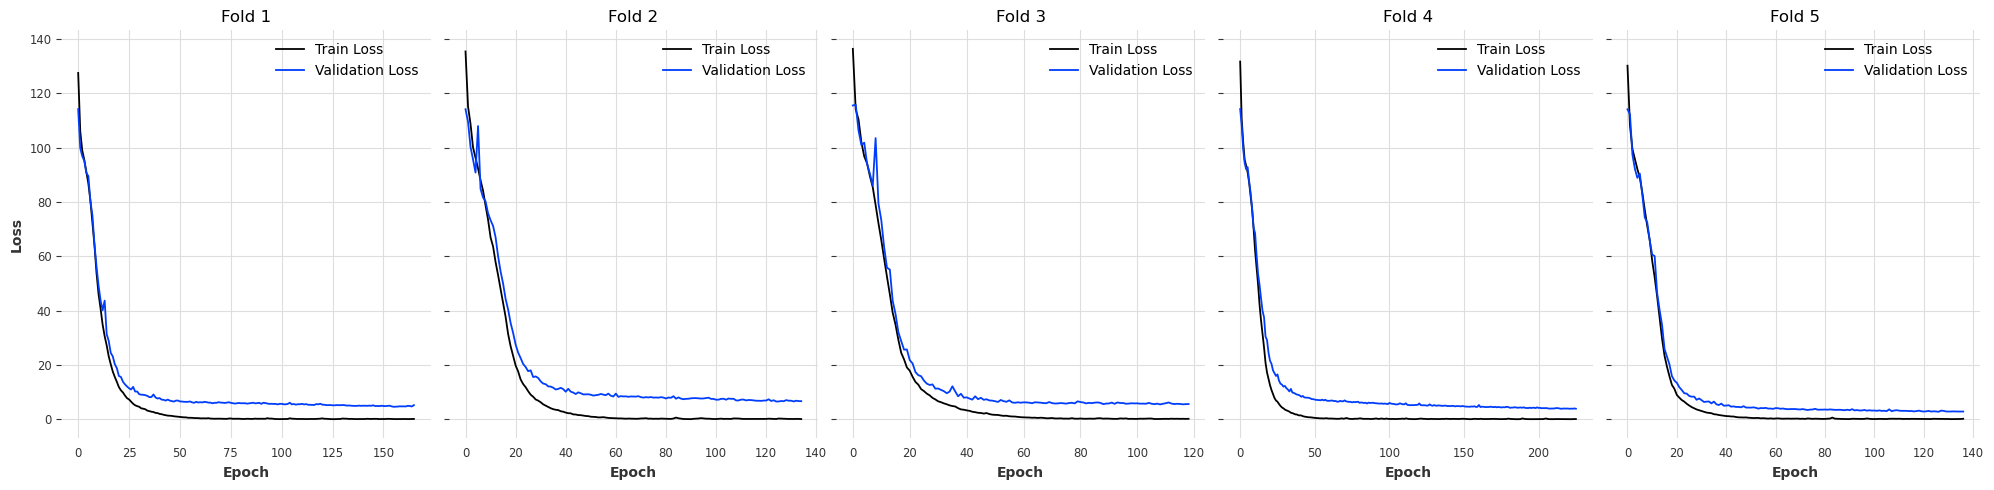

In [ ]:
from models.cnn_pytorch import CNNX1
from utils.train_pipeline import EarlyStopper, ModelTrainingPipeline, run_optuna_study, run_optuna_study
from utils.utils import print_study_results, plot_best_model_results


n_trials = 100
num_epochs = 500
model_type = "CNN"
model_name = "CNNX1"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "kernel_size": {
        "type": "categorical",
        "args": [[3, 5, 7]] 
    },
    "num_filters_1": {
        "type": "categorical",
        "args": [[16, 32, 64]]
    },
    "num_filters_2": {
        "type": "categorical",
        "args": [[16, 32, 64]]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["kernel_size", "num_filters_1", "num_filters_2"]

result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)

early_stopper = EarlyStopper(patience=10, min_delta=1e-5, min_epochs=100)
pipeline = ModelTrainingPipeline(device=device, early_stopper=early_stopper)

run_optuna_study(pipeline.run_cross_val, CNNX1, model_type, suggestion_dict, model_params_keys, seed, X1, None, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)


study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)

In [7]:
# from utils.utils import plot_preds_vs_truevalues
# from utils.train_pipeline import get_preds_best_config


# epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, CNNX1, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X1=X1, X2=None, y=y)

# # Plot the train and validation losses for each fold
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# for i in range(5):
#     axes[i].plot(epochs_train_losses[i], label="Train Loss")
#     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
#     axes[i].set_title(f"Fold {i + 1}")
#     axes[i].set_xlabel("Epoch")
#     if i == 0:
#         axes[i].set_ylabel("Loss")
#     axes[i].legend()

# plt.tight_layout()
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold)


[I 2024-12-06 17:46:07,655] A new study created in memory with name: no-name-2701b4a8-129d-4b0b-ac21-1a8795006f97


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49


[I 2024-12-06 17:46:43,759] Trial 0 finished with value: 88.00754241943359 and parameters: {'learning_rate': 2.6565450821928437e-05, 'kernel_size': 7, 'num_filters_1': 32, 'num_filters_2': 32, 'batch_size': 32}. Best is trial 0 with value: 88.00754241943359.


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49


[I 2024-12-06 17:47:32,512] Trial 1 finished with value: 45.121514892578126 and parameters: {'learning_rate': 4.818392406362461e-05, 'kernel_size': 5, 'num_filters_1': 32, 'num_filters_2': 16, 'batch_size': 16}. Best is trial 1 with value: 45.121514892578126.


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49


[I 2024-12-06 17:48:33,451] Trial 2 finished with value: 11.669772720336914 and parameters: {'learning_rate': 9.341580728256015e-05, 'kernel_size': 5, 'num_filters_1': 64, 'num_filters_2': 16, 'batch_size': 16}. Best is trial 2 with value: 11.669772720336914.


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49


[I 2024-12-06 17:49:47,620] Trial 3 finished with value: 3.0767226696014403 and parameters: {'learning_rate': 0.000189208970891818, 'kernel_size': 5, 'num_filters_1': 16, 'num_filters_2': 64, 'batch_size': 16}. Best is trial 3 with value: 3.0767226696014403.


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49


[I 2024-12-06 17:50:13,406] Trial 4 finished with value: 89.78235931396485 and parameters: {'learning_rate': 4.9194682623948277e-05, 'kernel_size': 7, 'num_filters_1': 32, 'num_filters_2': 64, 'batch_size': 128}. Best is trial 3 with value: 3.0767226696014403.


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49


[I 2024-12-06 17:50:32,062] Trial 5 finished with value: 42.12512321472168 and parameters: {'learning_rate': 0.0005023863055027174, 'kernel_size': 3, 'num_filters_1': 32, 'num_filters_2': 32, 'batch_size': 128}. Best is trial 3 with value: 3.0767226696014403.


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 46
Training completed all epochs. Best epoch was 48


[I 2024-12-06 17:51:22,362] Trial 6 finished with value: 0.2935235232114792 and parameters: {'learning_rate': 0.0005603141314659803, 'kernel_size': 5, 'num_filters_1': 32, 'num_filters_2': 16, 'batch_size': 16}. Best is trial 6 with value: 0.2935235232114792.


Training completed all epochs. Best epoch was 48
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 48


[I 2024-12-06 17:51:45,740] Trial 7 finished with value: 81.60596923828125 and parameters: {'learning_rate': 8.510049419061438e-05, 'kernel_size': 7, 'num_filters_1': 16, 'num_filters_2': 64, 'batch_size': 128}. Best is trial 6 with value: 0.2935235232114792.


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 48
Training completed all epochs. Best epoch was 49


[I 2024-12-06 17:52:34,488] Trial 8 finished with value: 35.973480987548825 and parameters: {'learning_rate': 9.034227631515063e-05, 'kernel_size': 7, 'num_filters_1': 32, 'num_filters_2': 64, 'batch_size': 32}. Best is trial 6 with value: 0.2935235232114792.


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 48
Training completed all epochs. Best epoch was 48


[I 2024-12-06 17:52:57,865] Trial 9 finished with value: 1.6855261087417603 and parameters: {'learning_rate': 0.0009792935271136904, 'kernel_size': 3, 'num_filters_1': 16, 'num_filters_2': 32, 'batch_size': 64}. Best is trial 6 with value: 0.2935235232114792.


Training completed all epochs. Best epoch was 49
Best hyperparameters: {'learning_rate': 0.0005603141314659803, 'kernel_size': 5, 'num_filters_1': 32, 'num_filters_2': 16, 'batch_size': 16}
Number of finished trials:  10
Best trial: 6
Best hyperparameters: {'learning_rate': 0.0005603141314659803, 'kernel_size': 5, 'num_filters_1': 32, 'num_filters_2': 16, 'batch_size': 16}
Validation Losses [0.20546305179595947, 0.40097013115882874, 0.20548434555530548, 0.32432252168655396, 0.3313775658607483]
Mean validation loss: 0.2935235232114792
Test Losses [0.2076844722032547, 0.5009470582008362, 0.27390575408935547, 0.352199524641037, 0.41012367606163025]
Mean test loss: 0.3489720970392227
Mean test MAE: 0.41853152513504027
Mean test RMSE: 0.5841466665267945


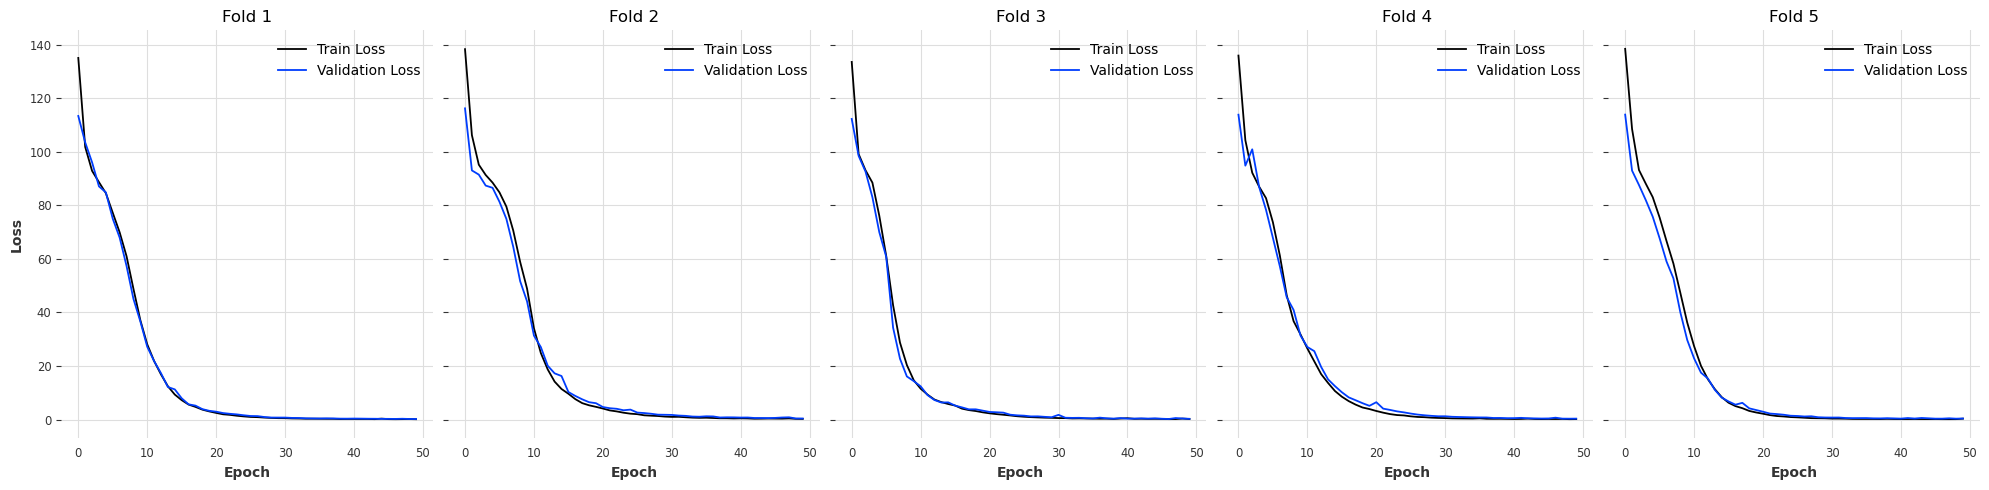

In [ ]:
from models.cnn_pytorch import CNNX1_X2Masking
from utils.train_pipeline import EarlyStopper, ModelTrainingPipeline

n_trials = 100
num_epochs = 500
model_type = "CNN"
model_name = "CNNX1_X2Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "kernel_size": {
        "type": "categorical",
        "args": [[3, 5, 7]] 
    },
    "num_filters_1": {
        "type": "categorical",
        "args": [[16, 32, 64]]
    },
    "num_filters_2": {
        "type": "categorical",
        "args": [[16, 32, 64]]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}


model_params_keys = ["kernel_size", "num_filters_1", "num_filters_2"]

#X1 shape is (num_samples, lookback_period)
masking_X1 = np.zeros((X1.shape[0], X1.shape[1])) 

for i, obs_motif_indexes in enumerate(X2):
    for j, idx in enumerate(obs_motif_indexes):
        masking_X1[i, idx.item():idx.item()+p] = 1

masking_X1 = torch.tensor(masking_X1, dtype=torch.float32)


result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

early_stopper = EarlyStopper(patience=10, min_delta=1e-5, min_epochs=100)
pipeline = ModelTrainingPipeline(device=device, early_stopper=early_stopper)


run_optuna_study(pipeline.run_cross_val, CNNX1_X2Masking, model_type, suggestion_dict, model_params_keys, seed, X1, masking_X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))

